# Test Keras GazeML implementation

**Note:** Importing cv2 can be problematic in jupyter due to issues with thread local storage (TLS)
Importing cv3 first works most of the time. If it fails restart the python kernel and try again until it works.    

In [1]:
import cv2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import dlib

# Load Neural networks

**Note:** this takes a long time on the Jetson Nano

In [5]:
MODEL_DIR = './3rdparty/'
FACE_DETECTION_MODEL = MODEL_DIR + 'haarcascade_frontalface_default.xml'
CNN_FACE_DETECTION_MODEL = MODEL_DIR + 'mmod_human_face_detector.dat'
LANDMARK_DETECTION_MODEL = MODEL_DIR + 'shape_predictor_68_face_landmarks.dat'
LANDMARK_5POINTS_DETECTION_MODEL = MODEL_DIR + 'shape_predictor_5_face_landmarks.dat'

cnn_face_detector = dlib.cnn_face_detection_model_v1(CNN_FACE_DETECTION_MODEL)
landmark_predictor = dlib.shape_predictor(LANDMARK_DETECTION_MODEL)

In [ ]:
from elg_keras import KerasELG

iris_model = KerasELG()
iris_model.net.load_weights("./3rdparty/elg_keras.h5")

In [7]:
def detect_face_cnn(gray):
    face_locations = cnn_face_detector(gray)
    if face_locations:
        faces_area = np.array([face.rect.area() for face in face_locations], dtype=np.int)
        biggest_face = np.argmax(faces_area)
        bounding_rect = face_locations[biggest_face].rect
        return np.array([bounding_rect.left(),
                         bounding_rect.top(),
                         bounding_rect.width(),
                         bounding_rect.height()], dtype=np.int)
    else:
        return None

In [8]:
def detect_landmarks_68(gray, rect):
    landmarks = landmark_predictor(gray, rect)
    points = [(p.x, p.y) for p in landmarks.parts()]
    landmark_dict = {
        "chin": points[0:17],
        "left_eyebrow": points[17:22],
        "right_eyebrow": points[22:27],
        "nose_bridge": points[27:31],
        "nose_tip": points[31:36],
        "left_eye": points[36:42],
        "right_eye": points[42:48],
        "top_lip": points[48:55] + [points[64]] + [points[63]] +
                   [points[62]] + [points[61]] + [points[60]],
        "bottom_lip": points[54:60] + [points[48]] + [points[60]] + [points[67]] +
                      [points[66]] + [points[65]] + [points[64]],
    }

    # map to equivalent points in the 5 point landmarks
    five_pt_landmarks = [points[45], points[42], points[36], points[39], points[33]]

    landmark_dict = {k: np.array(v, dtype=np.int) for k, v in landmark_dict.items()}
    return (landmark_dict, five_pt_landmarks)

# Load test image

In [9]:
fn = "./test_imgs/Lenna.png"
#fn = "./test_imgs/Anja.jpg"
input_img = cv2.imread(fn)[..., ::-1]

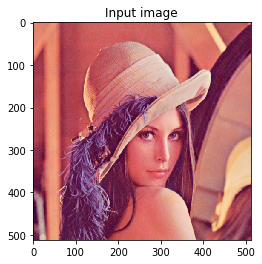

In [10]:
plt.title('Input image')
plt.imshow(input_img)

# Face detection

In [30]:
%%time
face_bounding_box = detect_face_cnn(input_img)
print(face_bounding_box)

[215 223 137 138]
CPU times: user 8 ms, sys: 8 ms, total: 16 ms
Wall time: 155 ms


In [31]:
%%time
x, y, w, h = tuple(face_bounding_box)
landmarks_68, landmarks_5 = detect_landmarks_68(input_img,
                                                dlib.rectangle(x, y, x + w, y + h))
print(landmarks_5)

[(341, 269), (319, 271), (255, 267), (285, 271), (308, 326)]
CPU times: user 20 ms, sys: 120 ms, total: 140 ms
Wall time: 141 ms


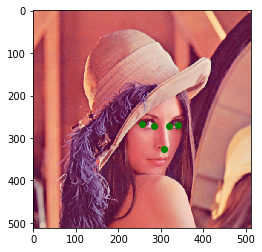

In [32]:
xs, ys = map(list, zip(*landmarks_5))
plt.imshow(input_img)
plt.plot(xs, ys, 'ro', color='g')
plt.show()

# Compute Eye region

In [33]:
lms = landmarks_5
right_eye_xy = (np.array(lms[0]) + np.array(lms[1])) / 2
left_eye_xy  = (np.array(lms[3]) + np.array(lms[2])) / 2

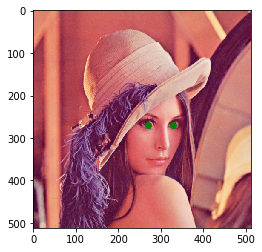

In [34]:
plt.imshow(input_img)
plt.plot([left_eye_xy[0], right_eye_xy[0]], [left_eye_xy[1], right_eye_xy[1]], 'ro', color='g')
plt.show()

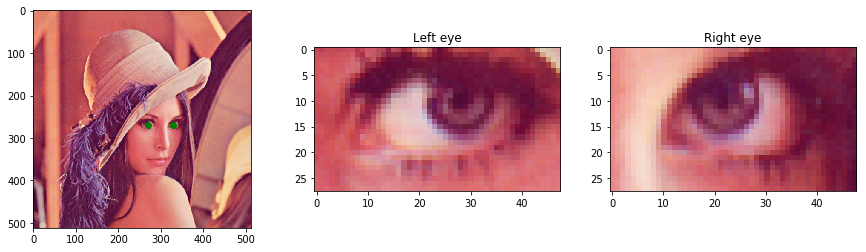

In [35]:
lms = landmarks_5
right_eye_xy = (np.array(lms[0]) + np.array(lms[1])) // 2
left_eye_xy  = (np.array(lms[3]) + np.array(lms[2])) // 2

dist_eyes = np.linalg.norm(left_eye_xy - right_eye_xy)
eye_bbox_w = (dist_eyes / 1.25)
eye_bbox_h = (eye_bbox_w *0.6)

left_eye_im = input_img[
    int(left_eye_xy[1]-eye_bbox_h//2):int(left_eye_xy[1]+eye_bbox_h//2),
    int(left_eye_xy[0]-eye_bbox_w//2):int(left_eye_xy[0]+eye_bbox_w//2), :]
# Flip left eye for iris detection
left_eye_im = left_eye_im[:,::-1,:]
right_eye_im = input_img[
    int(right_eye_xy[1]-eye_bbox_h//2):int(right_eye_xy[1]+eye_bbox_h//2),
    int(right_eye_xy[0]-eye_bbox_w//2):int(right_eye_xy[0]+eye_bbox_w//2), :]

plt.figure(figsize=(15,4))
plt.title('Annotation')
plt.subplot(1,3,1)
plt.imshow(input_img)
plt.plot([left_eye_xy[0], right_eye_xy[0]], [left_eye_xy[1], right_eye_xy[1]], 'ro', color='g')
plt.subplot(1,3,2)
plt.title('Left eye')
plt.imshow(left_eye_im)
plt.subplot(1,3,3)
plt.title('Right eye')
plt.imshow(right_eye_im)

# Prepocess Eye images

In [36]:
inp_left = cv2.cvtColor(left_eye_im, cv2.COLOR_RGB2GRAY)
inp_left = cv2.equalizeHist(inp_left)
inp_left = cv2.resize(inp_left, (180,108))[np.newaxis, ..., np.newaxis]

inp_right = cv2.cvtColor(right_eye_im, cv2.COLOR_RGB2GRAY)
inp_right = cv2.equalizeHist(inp_right)
inp_right = cv2.resize(inp_right, (180,108))[np.newaxis, ..., np.newaxis]

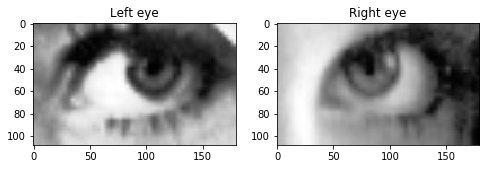

In [37]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.title('Left eye')
plt.imshow(inp_left[0,...,0], cmap="gray")
plt.subplot(1,2,2)
plt.title('Right eye')
plt.imshow(inp_right[0,...,0], cmap="gray")

# Predict iris landmarks

In [42]:
%%time
input_array = np.concatenate([inp_left, inp_right], axis=0)
pred_left, pred_right = iris_model.net.predict(input_array/255 * 2 - 1)

CPU times: user 212 ms, sys: 24 ms, total: 236 ms
Wall time: 232 ms


# Visualize output heatmaps

Eighteen heatmaps are predicted: 
- Eight heatmaps for iris (green)
- Eight heatmaps for eye-lid (red)
- Two heatmaps for pupil (blue)

In [43]:
def stretch_color(x):
    minimum = np.min(x)
    maximum = np.max(x)
    return ((x - minimum) / (maximum - minimum) * 255).astype(np.uint8)

In [44]:
hm_r = stretch_color(np.sum(pred_left[...,:8], axis=-1, keepdims=True))
hm_g = stretch_color(np.sum(pred_left[...,8:16], axis=-1, keepdims=True))
hm_b = stretch_color(np.sum(pred_left[...,16:], axis=-1, keepdims=True))
heatmaps_left = np.concatenate([hm_r, hm_g, hm_b], axis=-1)

In [45]:
hm_r = stretch_color(np.sum(pred_right[...,:8], axis=-1, keepdims=True))
hm_g = stretch_color(np.sum(pred_right[...,8:16], axis=-1, keepdims=True))
hm_b = stretch_color(np.sum(pred_right[...,16:], axis=-1, keepdims=True))
heatmaps_right = np.concatenate([hm_r, hm_g, hm_b], axis=-1)

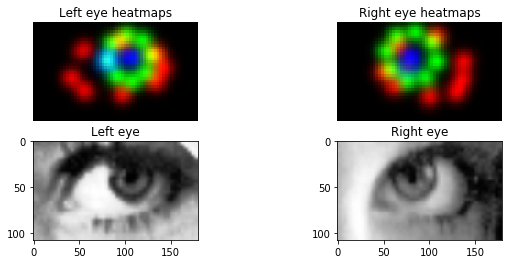

In [46]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.axis('off')
plt.title('Left eye heatmaps')
plt.imshow(heatmaps_left)
plt.subplot(2,2,2)
plt.axis('off')
plt.title('Right eye heatmaps')
plt.imshow(heatmaps_right)
plt.subplot(2,2,3)
plt.title('Left eye')
plt.imshow(inp_left[0,...,0], cmap="gray")
plt.subplot(2,2,4)
plt.title('Right eye')
plt.imshow(inp_right[0,...,0], cmap="gray")

# Draw eye region landmarks

In [47]:
def draw_pupil(im, inp_im, lms):
    draw = im.copy()
    draw = cv2.resize(draw, (inp_im.shape[2], inp_im.shape[1]))
    pupil_center = np.zeros((2,))
    pnts_outerline = []
    pnts_innerline = []
    stroke = 2 #inp_im.shape[1] // 12 + 1
    for i, lm in enumerate(np.squeeze(lms)):
        y, x = int(lm[0]*3), int(lm[1]*3)

        if i < 8:
            draw = cv2.circle(draw, (y, x), stroke, (125,255,125), -1)
            pnts_outerline.append([y, x])
        elif i < 16:
            draw = cv2.circle(draw, (y, x), stroke, (125,125,255), -1)
            pnts_innerline.append([y, x])
            pupil_center += (y,x)
        elif i < 17:
            draw = cv2.drawMarker(draw, (y, x), (255,200,200), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=stroke, line_type=cv2.LINE_AA)
        else:
            draw = cv2.drawMarker(draw, (y, x), (255,125,125), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=stroke, line_type=cv2.LINE_AA)
    pupil_center = (pupil_center/8).astype(np.int32)
    draw = cv2.circle(draw, (pupil_center[0], pupil_center[1]), stroke, (255,255,0), -1)        
    draw = cv2.polylines(draw, [np.array(pnts_outerline).reshape(-1,1,2)], isClosed=True, color=(125,255,125), thickness=stroke//2)
    draw = cv2.polylines(draw, [np.array(pnts_innerline).reshape(-1,1,2)], isClosed=True, color=(125,125,255), thickness=stroke//2)
    return draw

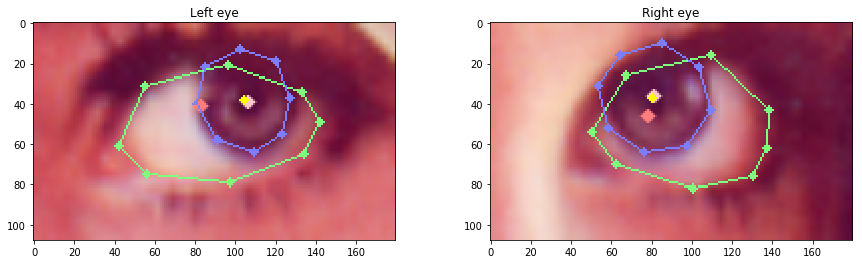

In [56]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title("Left eye")
lms_left = iris_model._calculate_landmarks(pred_left)
result_left = draw_pupil(left_eye_im, inp_left, lms_left)
plt.imshow(result_left)
plt.subplot(1,2,2)
plt.title("Right eye")
lms_right = iris_model._calculate_landmarks(pred_right)
result_right = draw_pupil(right_eye_im, inp_right, lms_right)
plt.imshow(result_right)

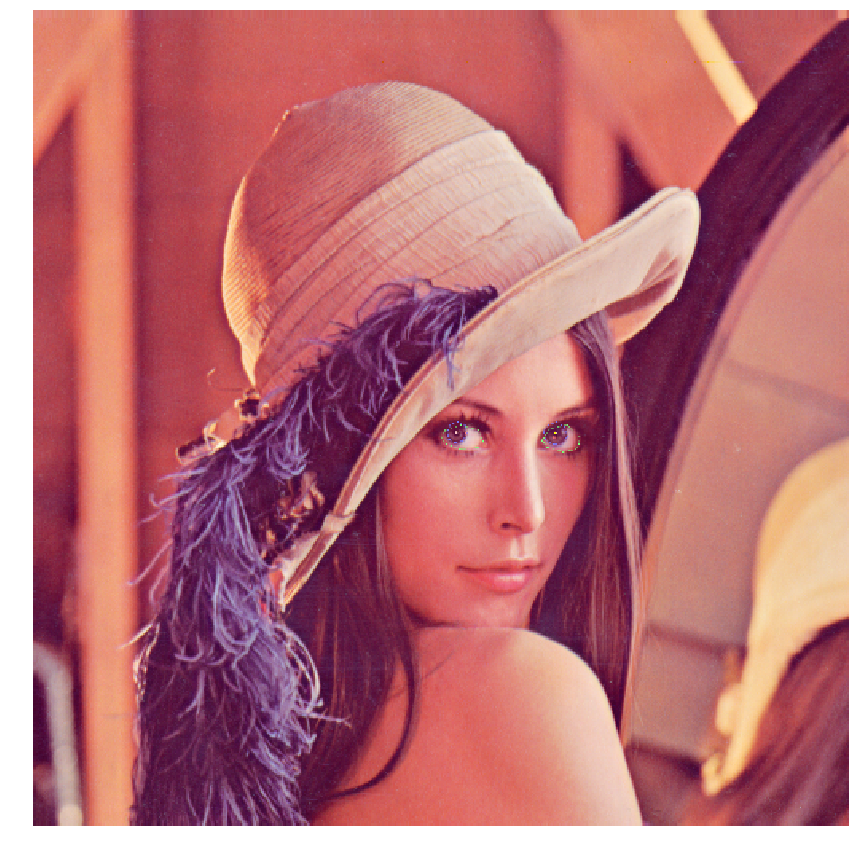

In [57]:
draw2 = input_img.copy()

slice_h = slice(int(left_eye_xy[1]-eye_bbox_h//2), int(left_eye_xy[1]+eye_bbox_h//2))
slice_w = slice(int(left_eye_xy[0]-eye_bbox_w//2), int(left_eye_xy[0]+eye_bbox_w//2))
im_shape = left_eye_im.shape[::-1]

draw2[slice_h, slice_w, :] = cv2.resize(result_left[:,::-1,:], im_shape[1:])

slice_h = slice(int(right_eye_xy[1]-eye_bbox_h//2), int(right_eye_xy[1]+eye_bbox_h//2))
slice_w = slice(int(right_eye_xy[0]-eye_bbox_w//2), int(right_eye_xy[0]+eye_bbox_w//2))
im_shape = right_eye_im.shape[::-1]

draw2[slice_h, slice_w, :] = cv2.resize(result_right, im_shape[1:])

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(draw2)